In [ ]:
# Python 3.12.10 - author: Carlos Brandon Cortes Cortina 
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, roc_curve,accuracy_score,precision_score,recall_score
import xgboost as xgb

# Extracción y vista de los datos

In [2]:
import kagglehub

# Download latest version
pathd = kagglehub.dataset_download("ethancratchley/email-phishing-dataset")

print("Path to dataset files:", pathd)

C:\Users\brand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\brand\.cache\kagglehub\datasets\ethancratchley\email-phishing-dataset\versions\1


In [3]:
# Ruta destino
dest_folder = "C:/DB/email-phishing-dataset"
dest_file = os.path.join(dest_folder, "email_phishing_data.csv")

# Crear carpeta de destino si no existe
os.makedirs(dest_folder, exist_ok=True)

# Ruta del archivo descargado
source_file = os.path.join(pathd, "email_phishing_data.csv")

# Mover archivo si no existe ya en destino
if not os.path.exists(dest_file):
    shutil.move(source_file, dest_file)

    print("Archivo movido exitosamente.")
else:
    print("El archivo ya existe en la carpeta destino.")

El archivo ya existe en la carpeta destino.


In [4]:
data = pd.read_csv(dest_file)
data.head()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0


In [5]:
data.info()
print('Variable target: label = 1 phishing email, label 0 = true email')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524846 entries, 0 to 524845
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   num_words            524846 non-null  int64
 1   num_unique_words     524846 non-null  int64
 2   num_stopwords        524846 non-null  int64
 3   num_links            524846 non-null  int64
 4   num_unique_domains   524846 non-null  int64
 5   num_email_addresses  524846 non-null  int64
 6   num_spelling_errors  524846 non-null  int64
 7   num_urgent_keywords  524846 non-null  int64
 8   label                524846 non-null  int64
dtypes: int64(9)
memory usage: 36.0 MB
Variable target: label = 1 phishing email, label 0 = true email


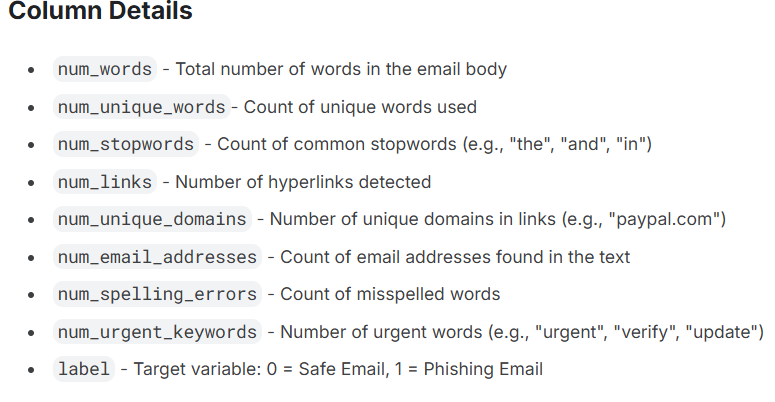

# Ajuste del modelo

In [6]:
seed = 42
model = RandomForestClassifier(n_estimators = 100, max_depth = 9, random_state = seed)
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)
#identificación de la Terget
X = data.drop(columns = ['label'])
Y = data['label']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = seed,shuffle = True)


In [7]:
# Entrenamiento para obtención de parámetros
model.fit(x_train,y_train)

RandomForestClassifier(max_depth=9, random_state=42)

# Métricas y conclusiones de las mismas

In [8]:
model.predict_proba(x_test)

array([[0.9803358 , 0.0196642 ],
       [0.99859307, 0.00140693],
       [0.99702794, 0.00297206],
       ...,
       [0.98555409, 0.01444591],
       [0.9869843 , 0.0130157 ],
       [0.98327349, 0.01672651]])

In [9]:
pred = model.predict(x_test)
recall = recall_score(y_test,pred)
precision = precision_score(y_test,pred)
f1 = f1_score(y_test,pred)
AUC = roc_auc_score(y_test,model.predict_proba(x_test)[:,1])
accuracy = accuracy_score(y_test,pred)
print(f'############### Informe de las KPI´s aplicadas ###############\nrecall:{recall}\nprecision:{precision}\nf1-score:{f1}\nAUC:{AUC}\naccuracy:{accuracy}')

############### Informe de las KPI´s aplicadas ###############
recall:0.0164638511095204
precision:0.9583333333333334
f1-score:0.03237156931738212
AUC:0.8230455841418888
accuracy:0.9869010193388588


###### Del resumen anterior podemos observar que el modelo presenta accuracy, AUC y precision en un Umbral que se considera acceptable. Sin embargo, el f1-score nos alerta de ciertas inconsistencias en las capacidades del modelo para hacer predicciones, y es en la precision donde podemos tener una idea de lo que sucede. Analicemos la curva ROC y la matriz de confusión. 

# Curva ROC y matriz de confusión

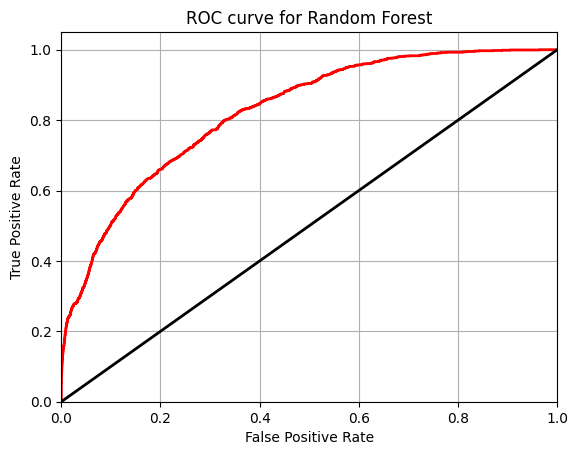

In [10]:
fpr, tpr, thresholds = roc_curve(y_test,model.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr,tpr, color = 'red', lw = 2, label = f'Área bajo la curva(AUC):f{AUC}')
plt.plot([1,0], [1,0], color = 'black', lw= 2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest')
plt.grid(True)

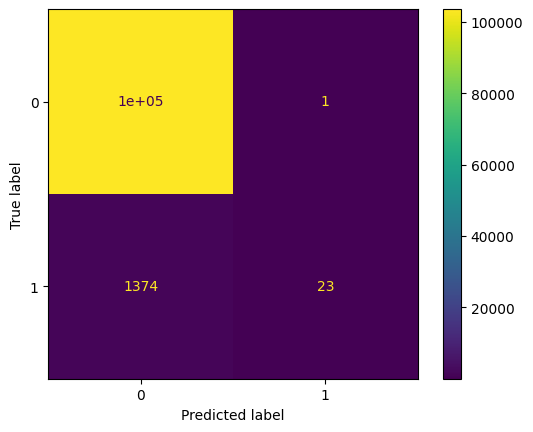

In [11]:
cm = confusion_matrix(y_test,pred,labels = model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
display.plot()

# Explicación

###### De la matriz de confusión podemos detectar los factores que afectan las KPI´s del modelo. Lo principal es resaltar que los datos están fuertemente cargados a la etiqueta cero (la mayoría de los E-mail no son phishing), y el modelo detecta mejor los casos que no son phishing eso lo podemos ver en la "presicion" es por ese motivo que el AUC y el accuracy resultan tan altos, sin embargo, el "F1_score" nos dice que algo está mal con nuestro modelo, siendo el "recall" el indicador que lo confirma y nos da un indicio del problema, y esto es el poco poder predictivo sobre la etiqueta 1 (Los phishing). De lo anterior debemos concluir lo siguiente:

# Conclusión

###### El modelo actual no es efectivo para detectar los correos phishing, por lo que se recomienda hacer un análisis de características para detectar aquellas que tienen mayor poder predictio sobre la ariable de interés, hacer un análisis sobre los hiperparámetros para mejorar el ajuste y si lo anterior sigue sin arrojar resultados se pueden probar fiderentes modelos calificados mediante el f1_score para vislumbrar uno y ajustarloal problema. 